In [1]:
import logging
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor

from dataset import MaskDataset, get_img_files
from nets.MobileNetV2_unet import MobileNetV2_unet

np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.manual_seed(1)

In [2]:
N_CV = 5
IMG_SIZE = 224

RANDOM_STATE = 1

EXPERIMENT = 'train_unet'
OUT_DIR = 'outputs/{}'.format(EXPERIMENT)

In [3]:
def get_data_loaders(val_files):
    val_transform = Compose([
        Resize((IMG_SIZE, IMG_SIZE)),
        ToTensor(),
    ])

    val_loader = DataLoader(MaskDataset(val_files, val_transform),
                            batch_size=1,
                            shuffle=False,
                            pin_memory=True,
                            num_workers=4)

    return val_loader


def evaluate():
    img_size = (IMG_SIZE, IMG_SIZE)
    n_shown = 0

    image_files = get_img_files()
    kf = KFold(n_splits=N_CV, random_state=RANDOM_STATE, shuffle=True)

    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    for n, (train_idx, val_idx) in enumerate(kf.split(image_files)):
        val_files = image_files[val_idx]
        data_loader = get_data_loaders(val_files)

        model = MobileNetV2_unet()
        model.load_state_dict(torch.load('{}/{}-best.pth'.format(OUT_DIR, n)))
        model.to(device)
        model.eval()

        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)

                for i, l, o in zip(inputs, labels, outputs):
                    i = i.cpu().numpy().transpose((1, 2, 0)) * 255
                    l = l.cpu().numpy().reshape(*img_size) * 255
                    o = o.cpu().numpy().reshape(int(IMG_SIZE / 2), int(IMG_SIZE / 2)) * 255

                    i = cv2.resize(i.astype(np.uint8), img_size)
                    l = cv2.resize(l.astype(np.uint8), img_size)
                    o = cv2.resize(o.astype(np.uint8), img_size)

                    plt.subplot(131)
                    plt.imshow(i)
                    plt.subplot(132)
                    plt.imshow(l)
                    plt.subplot(133)
                    plt.imshow(o)
                    plt.show()
                    n_shown += 1
                    if n_shown >= 5:
                        return

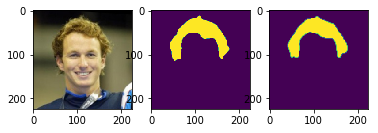

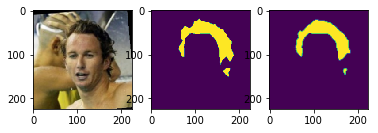

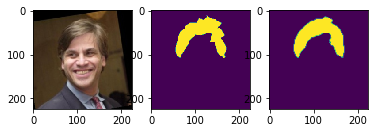

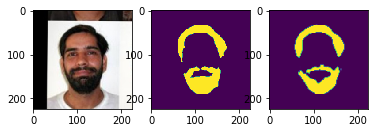

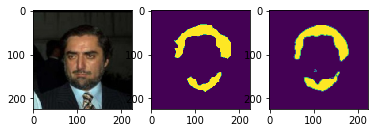

In [4]:
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

logger = logging.getLogger("logger")
logger.setLevel(logging.DEBUG)
if not logger.hasHandlers():
    logger.addHandler(logging.FileHandler(filename="outputs/{}.log".format(EXPERIMENT)))

evaluate()